# Variables with the same importance, testing repetitions, and random data generation  

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
from vi_evi import vi_evi

In [2]:
RANDOM_SEED = 4579
np.random.seed(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

## Data generation  
We start with a function with the values generated only once.  
We perform a first run to get the ranking of the variable importance.

In [3]:
X = pd.DataFrame(
    np.random.uniform(low=0, high=1.0, size=(100, 5)), columns=list("01234")
)
f_x = np.sum(X, axis=1)
Y = np.random.normal(f_x, 1)

In [4]:
with pm.Model() as model:
    μ = pmb.BART("μ", X, Y, m=50)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=Y)
    idata = pm.sample(
        chains=4, compute_convergence_checks=False, random_seed=RANDOM_SEED
    )

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.


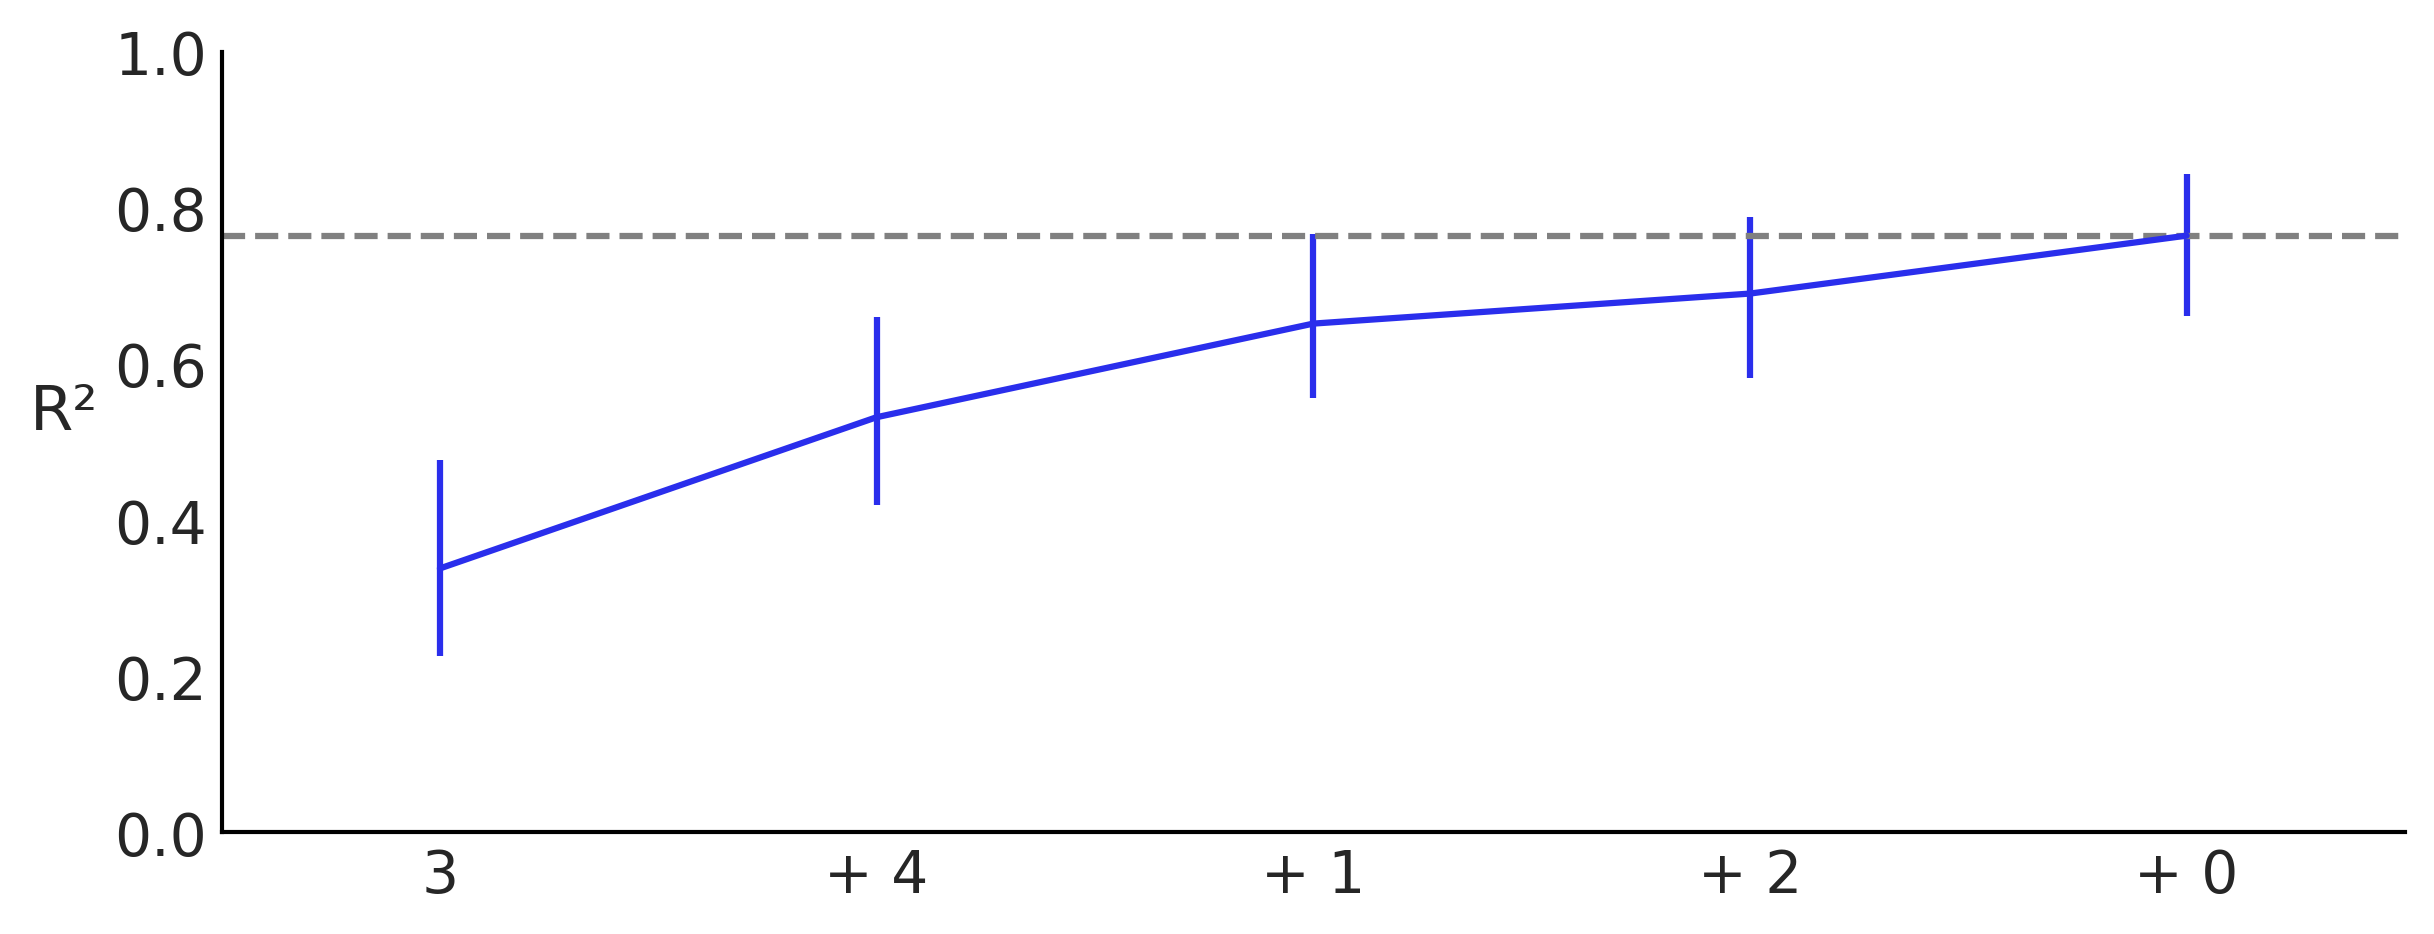

In [5]:
indices_vi, axes = pmb.plot_variable_importance(
    idata,
    μ,
    X,
    method="VI",
);

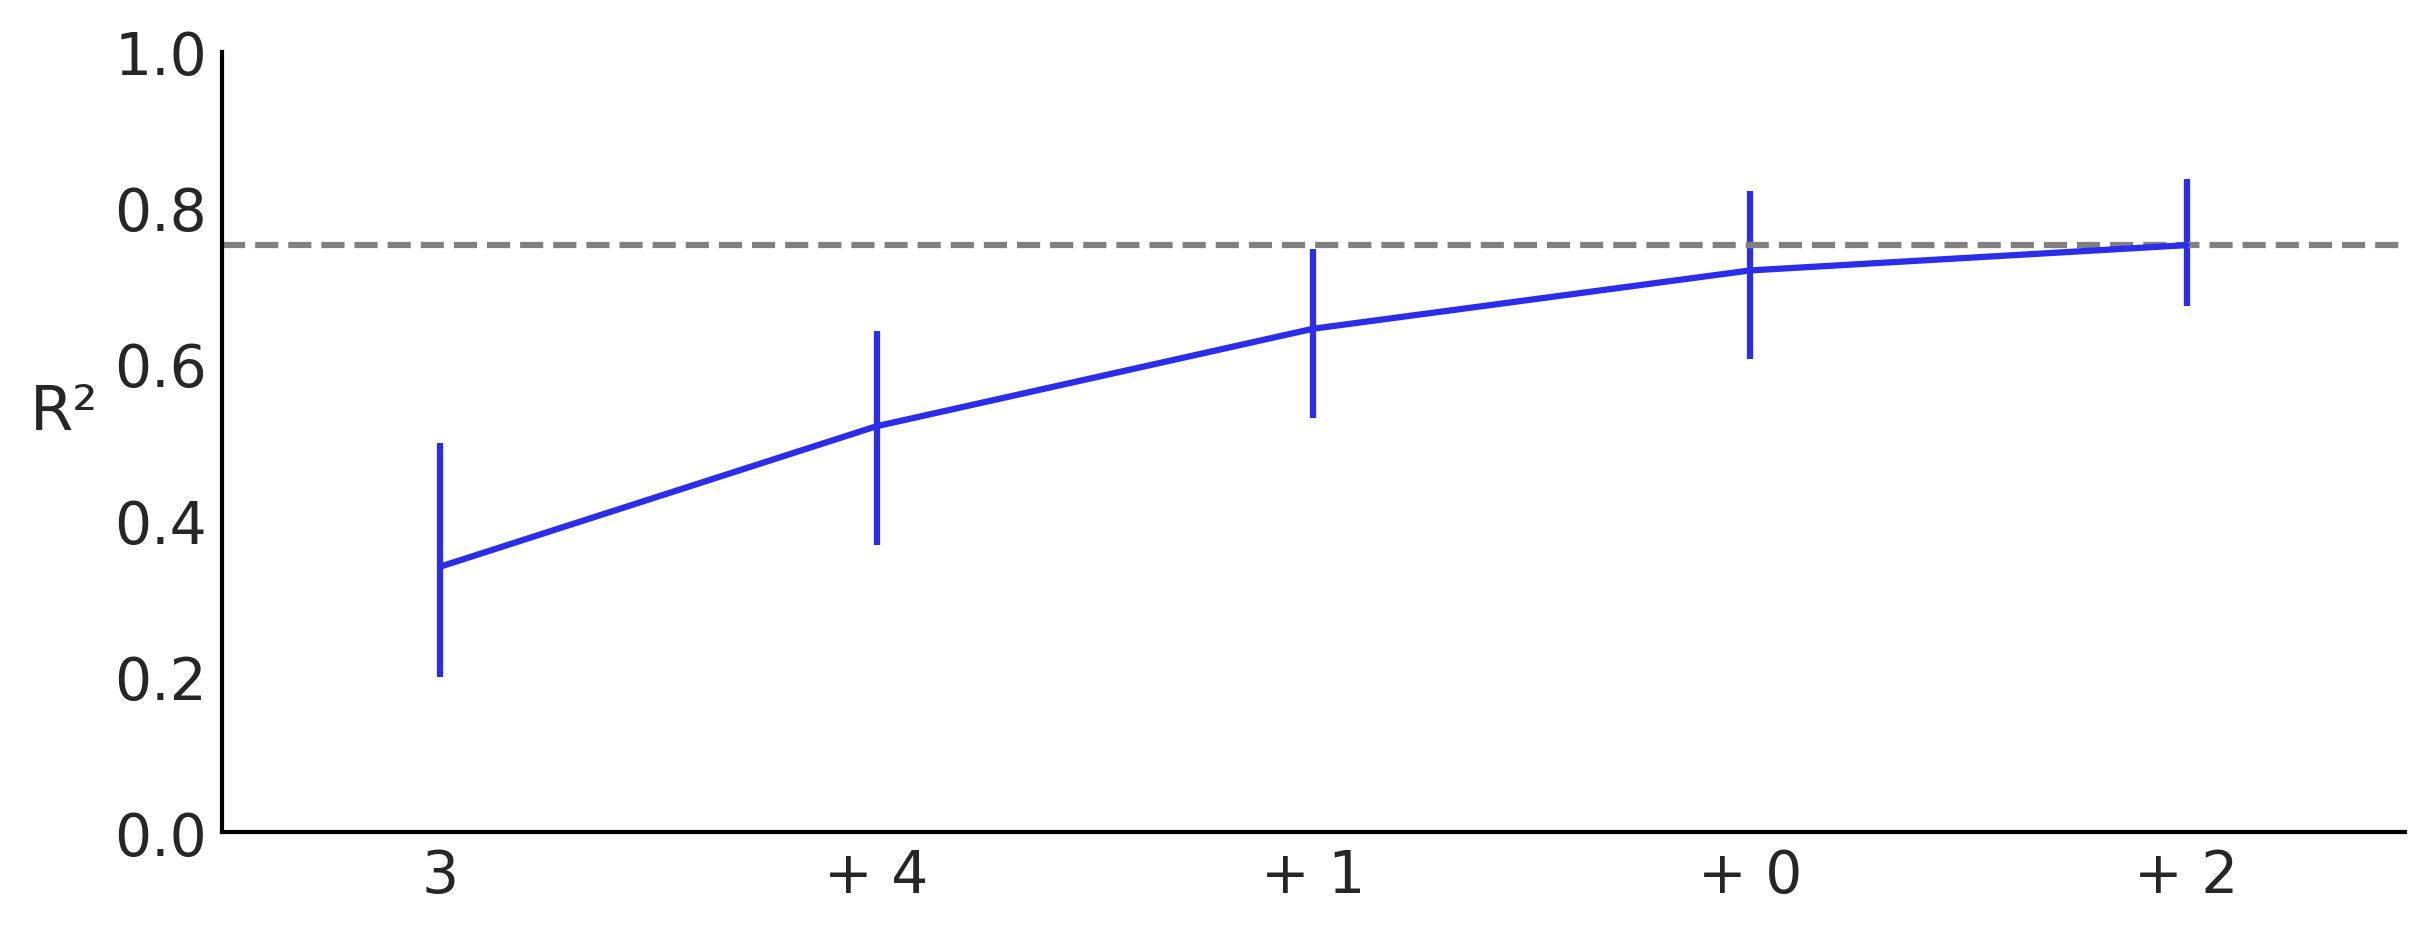

In [6]:
indices_bw, _ = pmb.plot_variable_importance(idata, μ, X, method="backward")

### Explicit computation of R² following `method="VI"` order, with `m=50`

In [7]:
idatas = []
trees = []
for idx in range(X.shape[1]):
    with pm.Model() as model:
        μ = pmb.BART("μ", X.iloc[:, indices_vi[: idx + 1]], Y, m=50)
        σ = pm.HalfNormal("σ", 1)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata = pm.sample(
            chains=4,
            compute_convergence_checks=False,
            random_seed=RANDOM_SEED,
        )
        idatas.append(idata)
        trees.append(μ)

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.


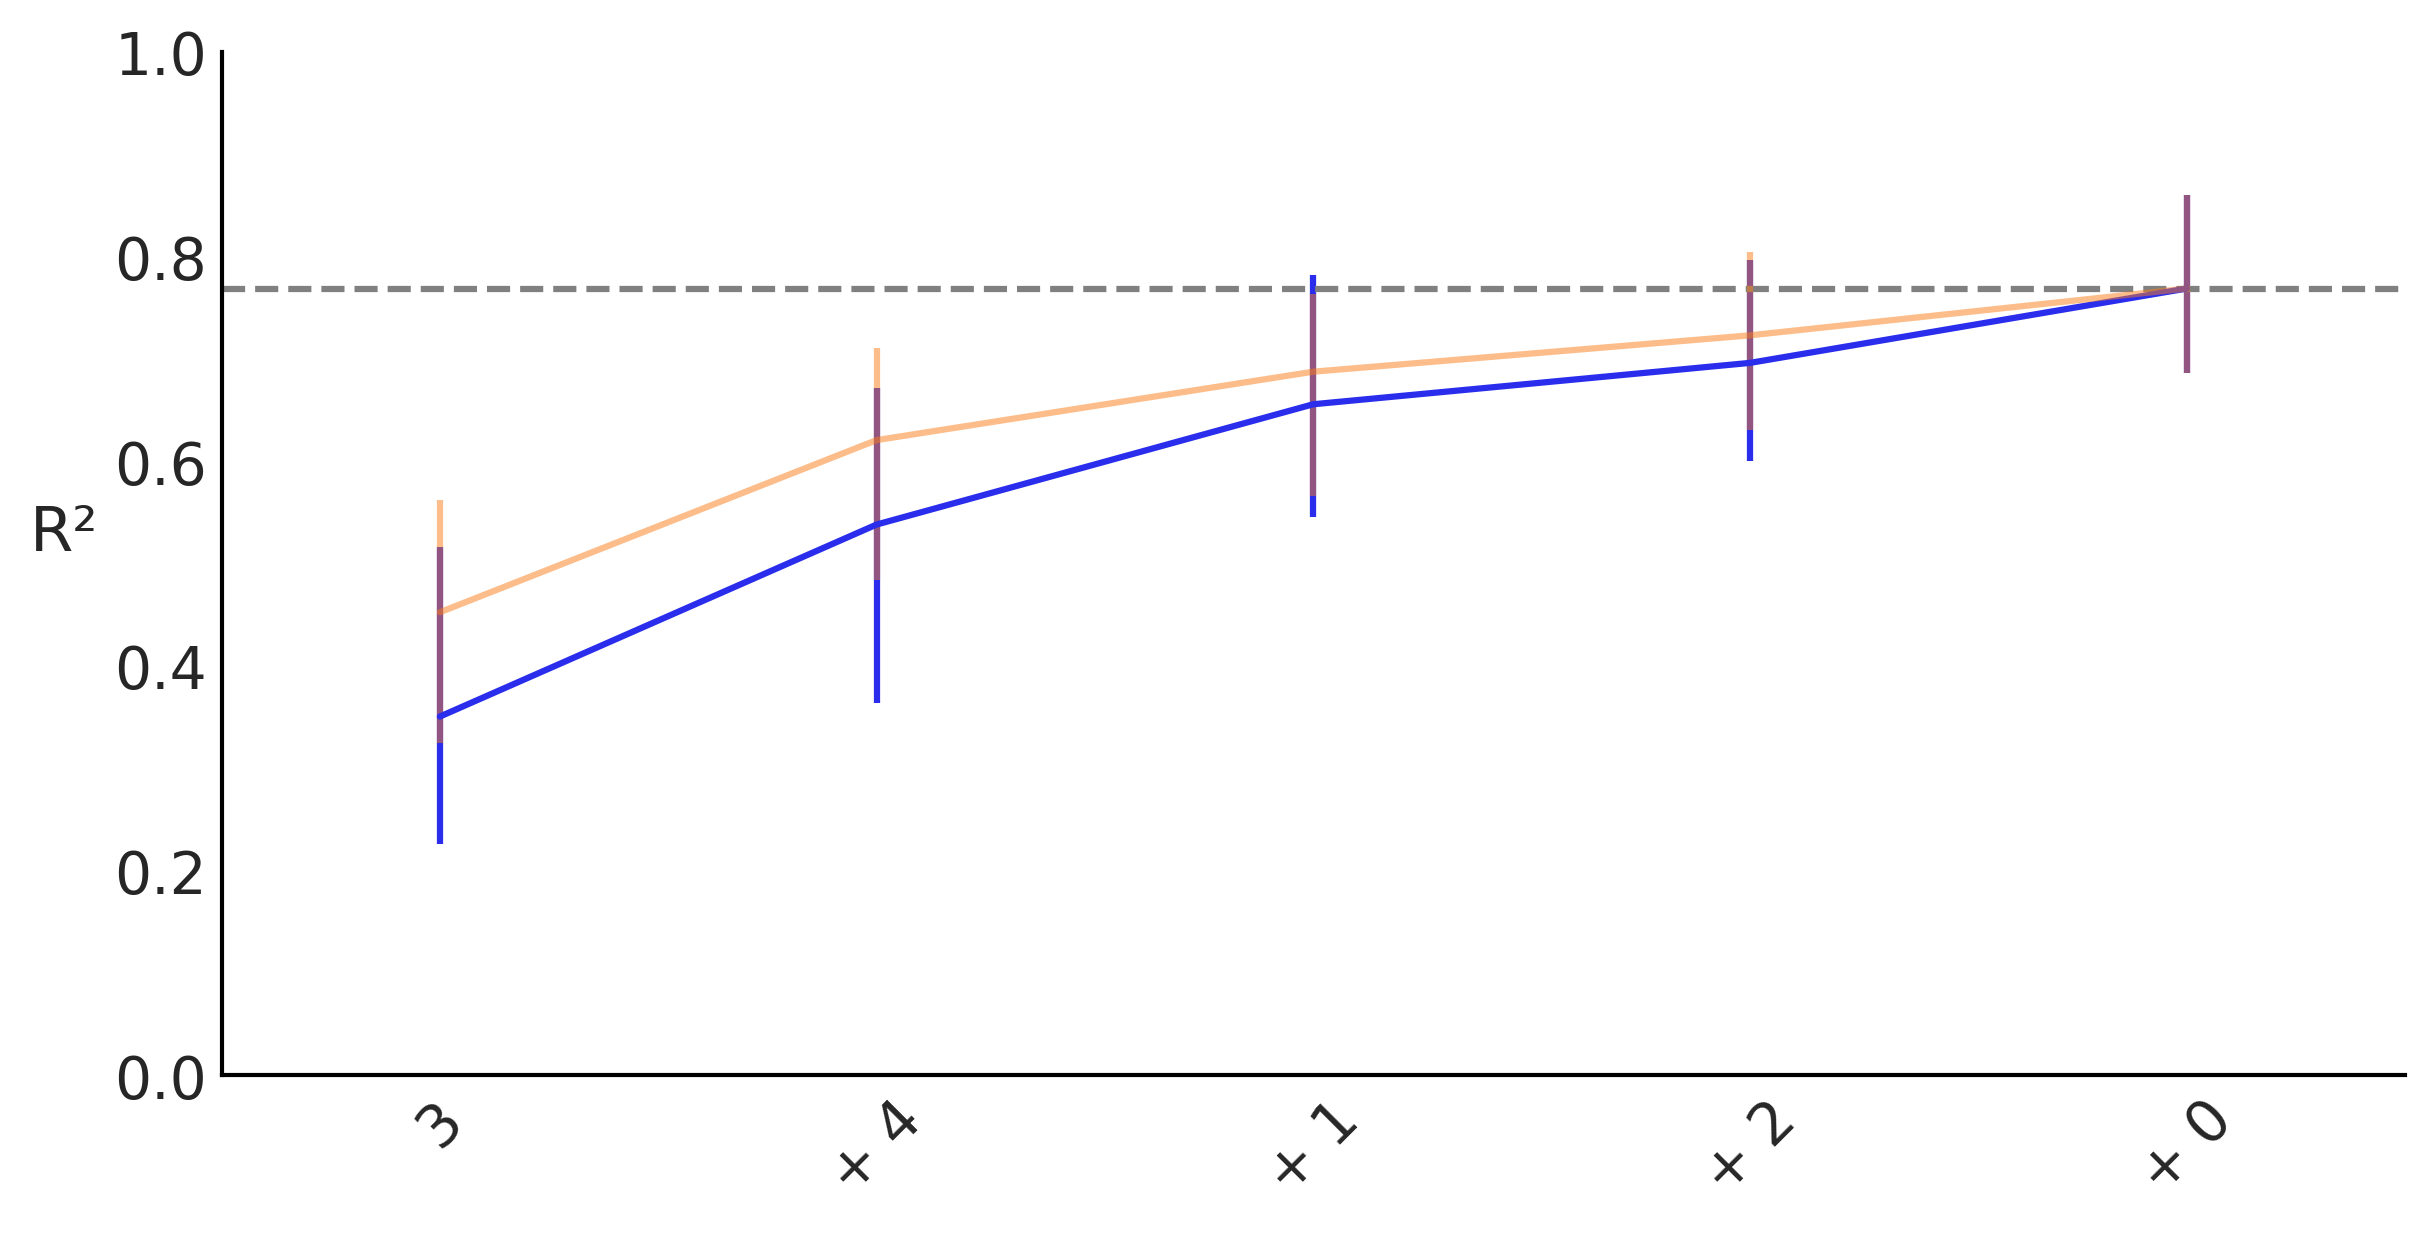

In [8]:
vi_evi(trees, idatas, X, indices_vi, "VI", 100, RANDOM_SEED, figsize=(8, 4))
plt.savefig("VI-similar_m50_vi.png");

### Explicit computation of R² following `method="backward"` order, with `m=50`

In [9]:
idatas = []
trees = []
for idx in range(X.shape[1]):
    with pm.Model() as model:
        μ = pmb.BART("μ", X.iloc[:, indices_bw[: idx + 1]], Y, m=50)
        σ = pm.HalfNormal("σ", 1)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata = pm.sample(
            chains=4,
            compute_convergence_checks=False,
            random_seed=RANDOM_SEED,
        )
        idatas.append(idata)
        trees.append(μ)

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.


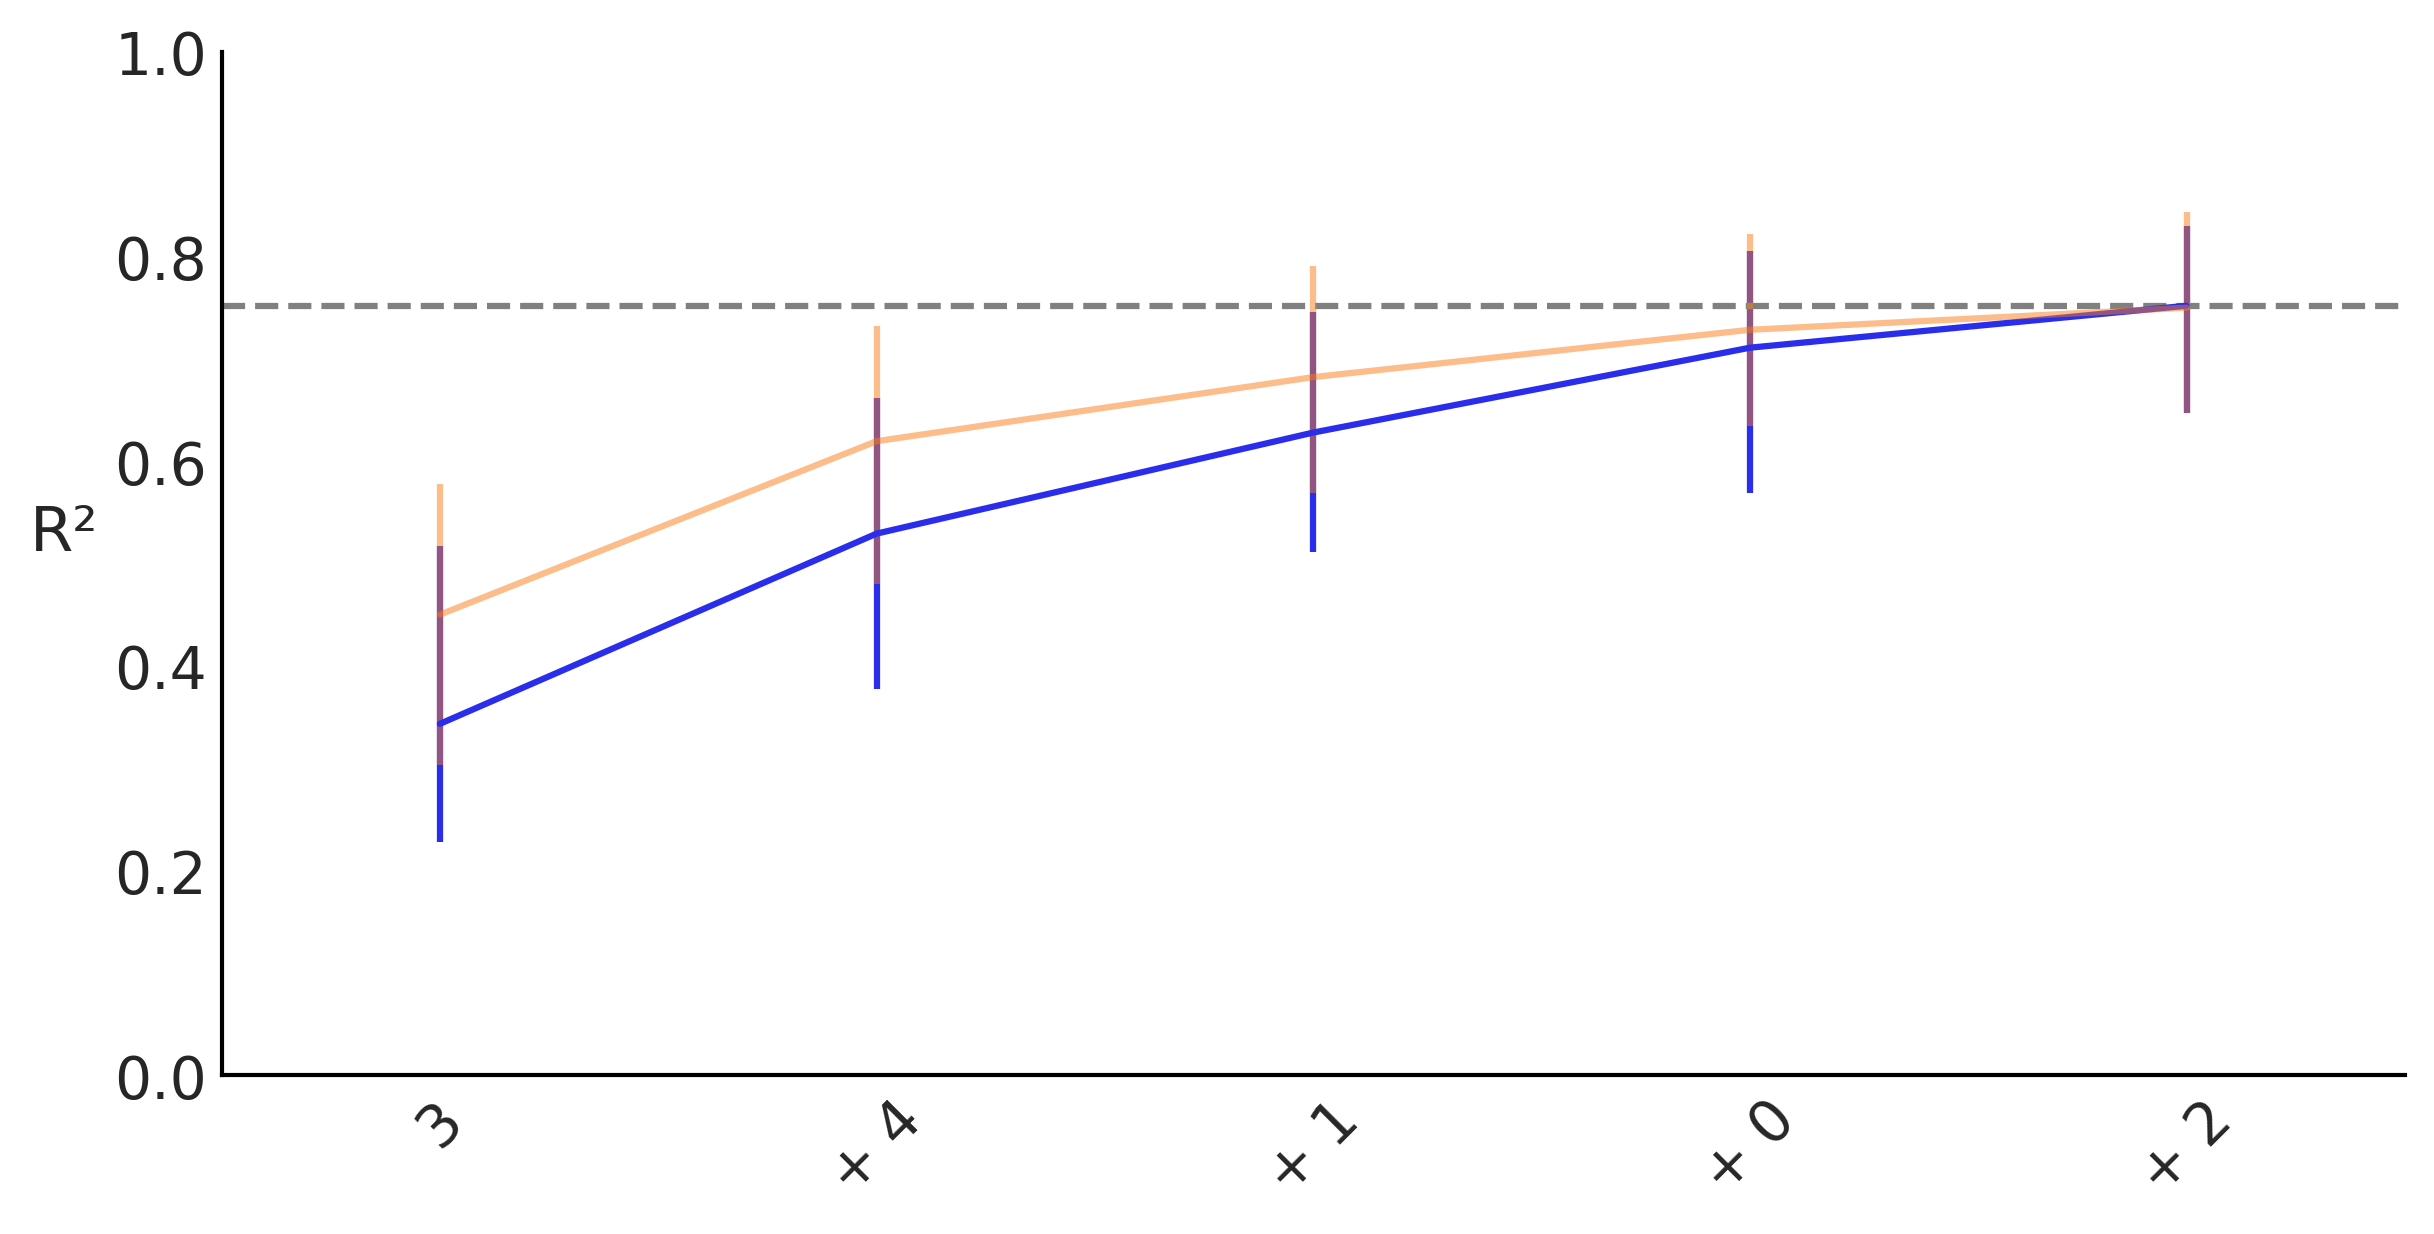

In [10]:
vi_evi(trees, idatas, X, indices_bw, "backward", 100, RANDOM_SEED, figsize=(8, 4))
plt.savefig("VI-similar_m50_bw.png");

## Repetitions of the same experiment  

### 50 repetitions, values generated only once  

In [11]:
VIs_50 = []
for _ in range(50):
    with pm.Model() as model:
        μ = pmb.BART("μ", X, Y, m=50)
        σ = pm.HalfNormal("σ", 1)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata_50 = pm.sample(
            chains=4,
            compute_convergence_checks=False,
            random_seed=RANDOM_SEED,
        )
    VI = idata_50.sample_stats["variable_inclusion"].mean(("chain", "draw")).values
    VIs_50.append(VI / VI.sum())

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.


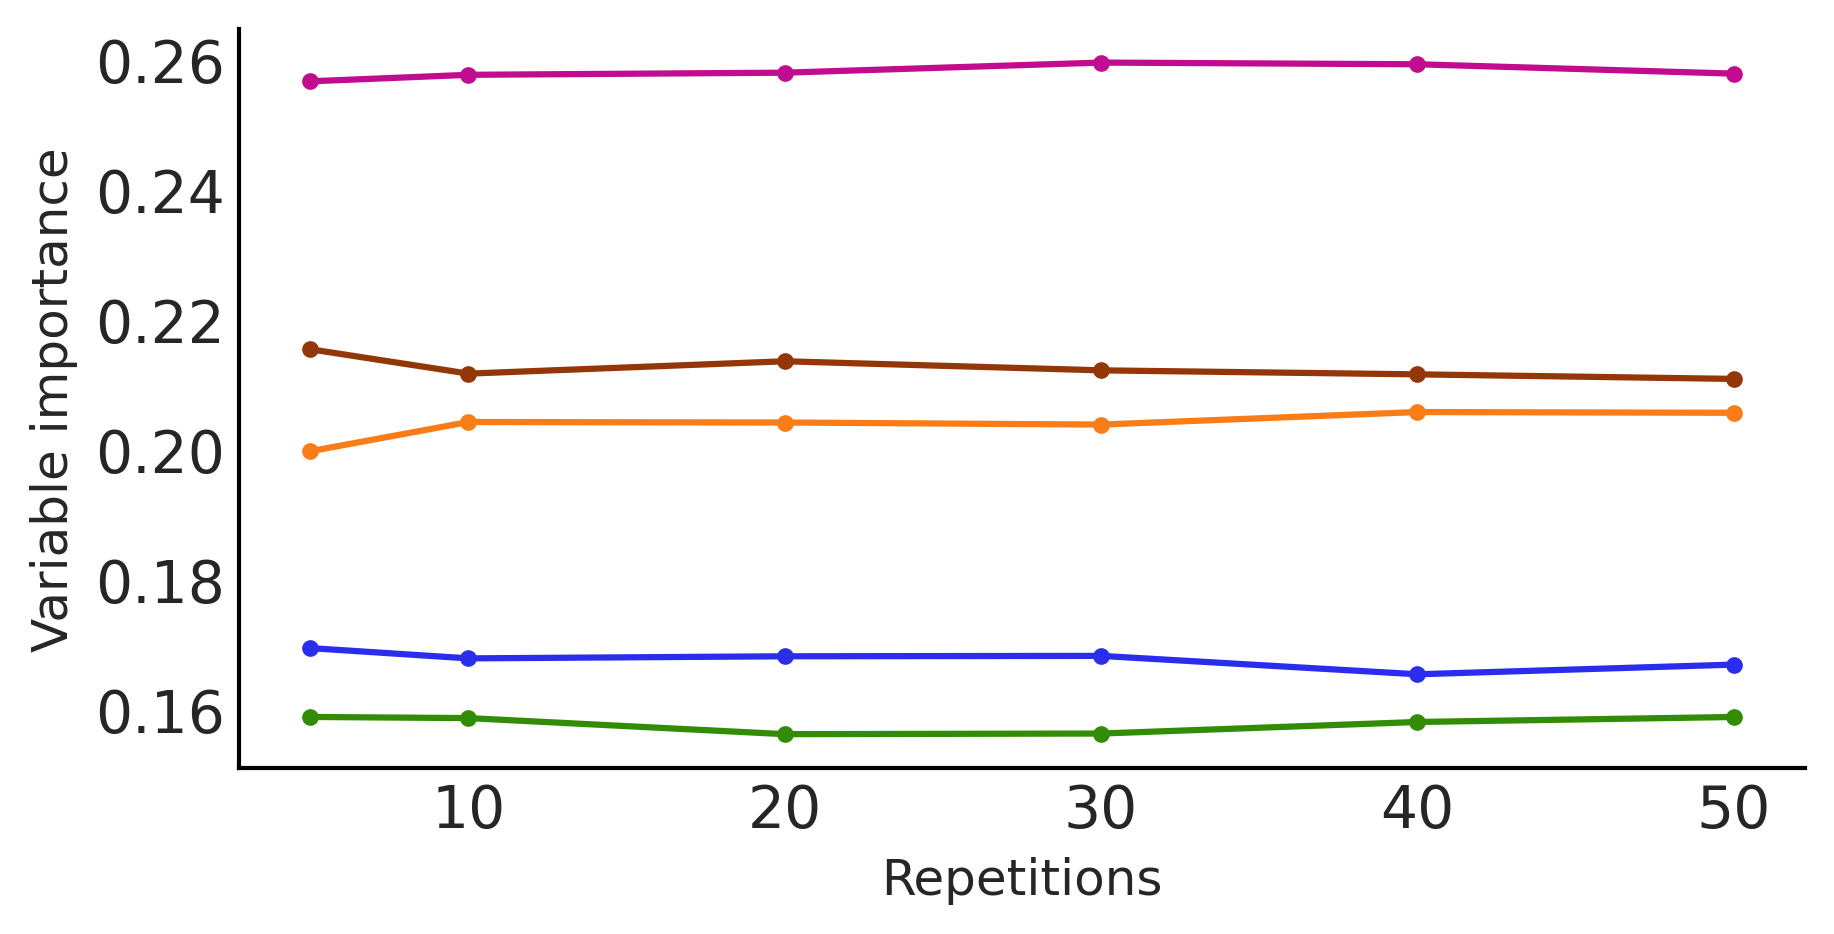

In [12]:
N = [5, 10, 20, 30, 40, 50]
vis_arr = np.array(VIs_50)
vi_v_mean = np.zeros((len(N), vis_arr.shape[1]))
for idx, n in enumerate(N):
    for i in range(X.shape[1]):
        vi_v_mean[idx:, i] = vis_arr[:, i][0 : n - 1].mean()

_, axes = plt.subplots(figsize=(6, 3))
axes.plot(N, vi_v_mean, ".-")
axes.set_xlabel("Repetitions", fontsize=12)
axes.set_ylabel("Variable importance", fontsize=12)
plt.savefig("VI-similar_50r_once.png");

### 50 repetitions, generating data in each repetition  

In [13]:
VIs_50_r = []
for _ in range(50):
    X = np.random.uniform(low=0, high=1.0, size=(100, 5))
    f_x = np.sum(X, axis=1)
    Y = np.random.normal(f_x, 1)
    with pm.Model() as model:
        μ = pmb.BART("μ", X, Y, m=50)
        σ = pm.HalfNormal("σ", 1)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata_50_r = pm.sample(
            chains=4,
            compute_convergence_checks=False,
            random_seed=RANDOM_SEED,
        )
    VI = idata.sample_stats["variable_inclusion"].mean(("chain", "draw")).values
    VIs_50_r.append(VI / VI.sum())

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.


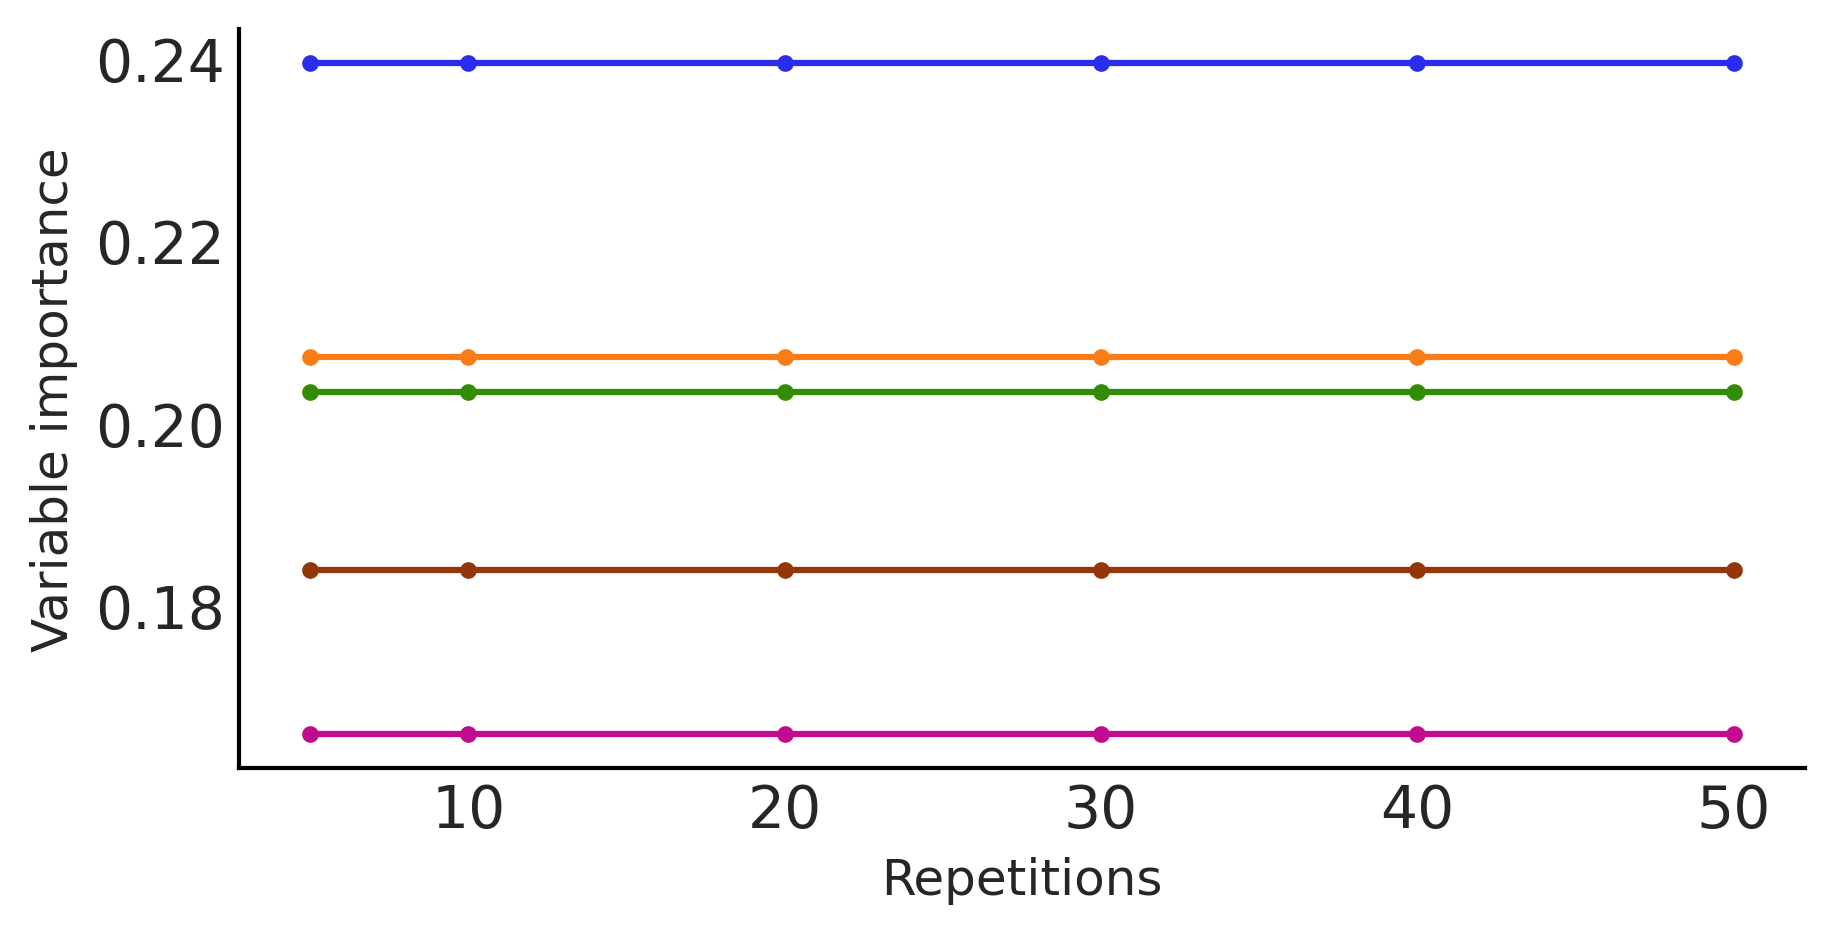

In [14]:
N50r = [5, 10, 20, 30, 40, 50]
vis_arr_50r = np.array(VIs_50_r)
vi_v_mean_50r = np.zeros((len(N50r), vis_arr_50r.shape[1]))
for idx, n in enumerate(N50r):
    for i in range(0, X.shape[1]):
        vi_v_mean_50r[idx:, i] = vis_arr_50r[:, i][0 : n - 1].mean()

_, axes = plt.subplots(figsize=(6, 3))
axes.plot(N50r, vi_v_mean_50r, ".-")
axes.set_xlabel("Repetitions", fontsize=12)
axes.set_ylabel("Variable importance", fontsize=12)
plt.savefig("VI-similar_50r_each.png");

### 150 repetitions, generating data in each repetition  

In [17]:
VIs_150 = []
for _ in range(150):
    X = np.random.uniform(low=0, high=1.0, size=(100, 5))
    f_x = np.sum(X, axis=1)
    Y = np.random.normal(f_x, 1)
    with pm.Model() as model:
        μ = pmb.BART("μ", X, Y, m=50)
        σ = pm.HalfNormal("σ", 1)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata = pm.sample(
            chains=4,
            compute_convergence_checks=False,
            random_seed=RANDOM_SEED,
        )
    VI = idata.sample_stats["variable_inclusion"].mean(("chain", "draw")).values
    VIs_150.append(VI / VI.sum())

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.


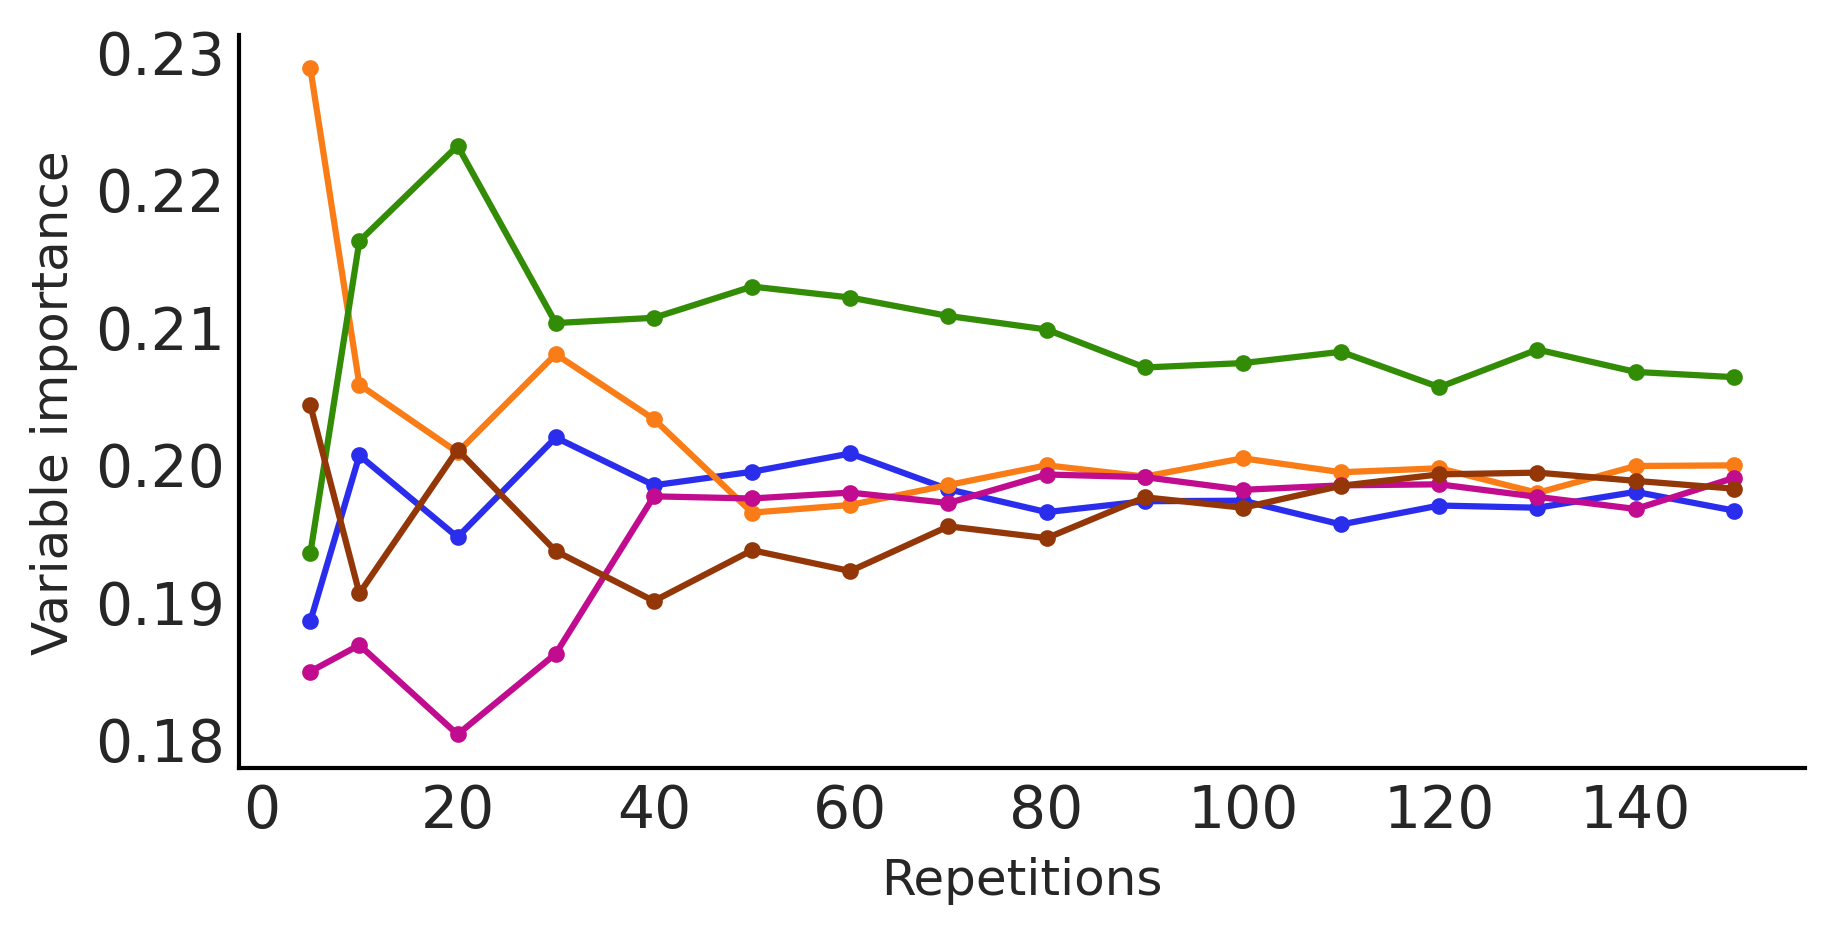

In [18]:
N150 = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
vis_arr_150r = np.array(VIs_150)
vi_v_mean_150r = np.zeros((len(N150), vis_arr_150r.shape[1]))
vi_v_std_150r = np.zeros((len(N150), vis_arr_150r.shape[1]))
for idx, n in enumerate(N150):
    for i in range(0, X.shape[1]):
        vi_v_mean_150r[idx:, i] = vis_arr_150r[:, i][0 : n - 1].mean()
        vi_v_std_150r[idx:, i] = vis_arr_150r[:, i][0 : n - 1].std()

_, axes = plt.subplots(figsize=(6, 3))
axes.plot(N150, vi_v_mean_150r, ".-")
axes.set_xlabel("Repetitions", fontsize=12)
axes.set_ylabel("Variable importance", fontsize=12)
plt.savefig("VI-similar_150r_each.png");

### 150 repetitions, generating data in each repetition, with 5000 draws  

In [19]:
VIs_1k = []
VIs_5k = []
for _ in range(150):
    X = np.random.uniform(low=0, high=1.0, size=(100, 5))
    f_x = np.sum(X, axis=1)
    Y = np.random.normal(f_x, 1)
    with pm.Model() as model:
        μ = pmb.BART("μ", X, Y, m=50)
        σ = pm.HalfNormal("σ", 1)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata = pm.sample(
            chains=4,
            draws=5000,
            compute_convergence_checks=False,
            random_seed=RANDOM_SEED,
            idata_kwargs={"log_likelihood": False},
        )
    VI_1k = (
        idata.sample_stats.sel(draw=slice(999))["variable_inclusion"]
        .mean(("chain", "draw"))
        .values
    )
    VIs_1k.append(VI_1k / VI_1k.sum())
    VI_5k = idata.sample_stats["variable_inclusion"].mean(("chain", "draw")).values
    VIs_5k.append(VI_5k / VI_5k.sum())

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 232 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 232 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 225 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 226 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 226 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 232 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 226 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 226 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 226 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 232 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 226 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 233 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 227 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 232 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 231 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 233 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 228 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 229 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 232 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 230 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 232 seconds.


In [20]:
N = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

vis_arr_1k = np.array(VIs_1k)
vi_v_mean_1k = np.zeros((len(N), vis_arr_1k.shape[1]))
vi_v_std_1k = np.zeros((len(N), vis_arr_1k.shape[1]))

vis_arr_5k = np.array(VIs_5k)
vi_v_mean_5k = np.zeros((len(N), vis_arr_5k.shape[1]))
vi_v_std_5k = np.zeros((len(N), vis_arr_5k.shape[1]))

for idx, n in enumerate(N):
    for i in range(0, X.shape[1]):
        vi_v_mean_1k[idx:, i] = vis_arr_1k[:, i][0 : n - 1].mean()
        vi_v_std_1k[idx:, i] = vis_arr_1k[:, i][0 : n - 1].std()
        vi_v_mean_5k[idx:, i] = vis_arr_5k[:, i][0 : n - 1].mean()
        vi_v_std_5k[idx:, i] = vis_arr_5k[:, i][0 : n - 1].std()

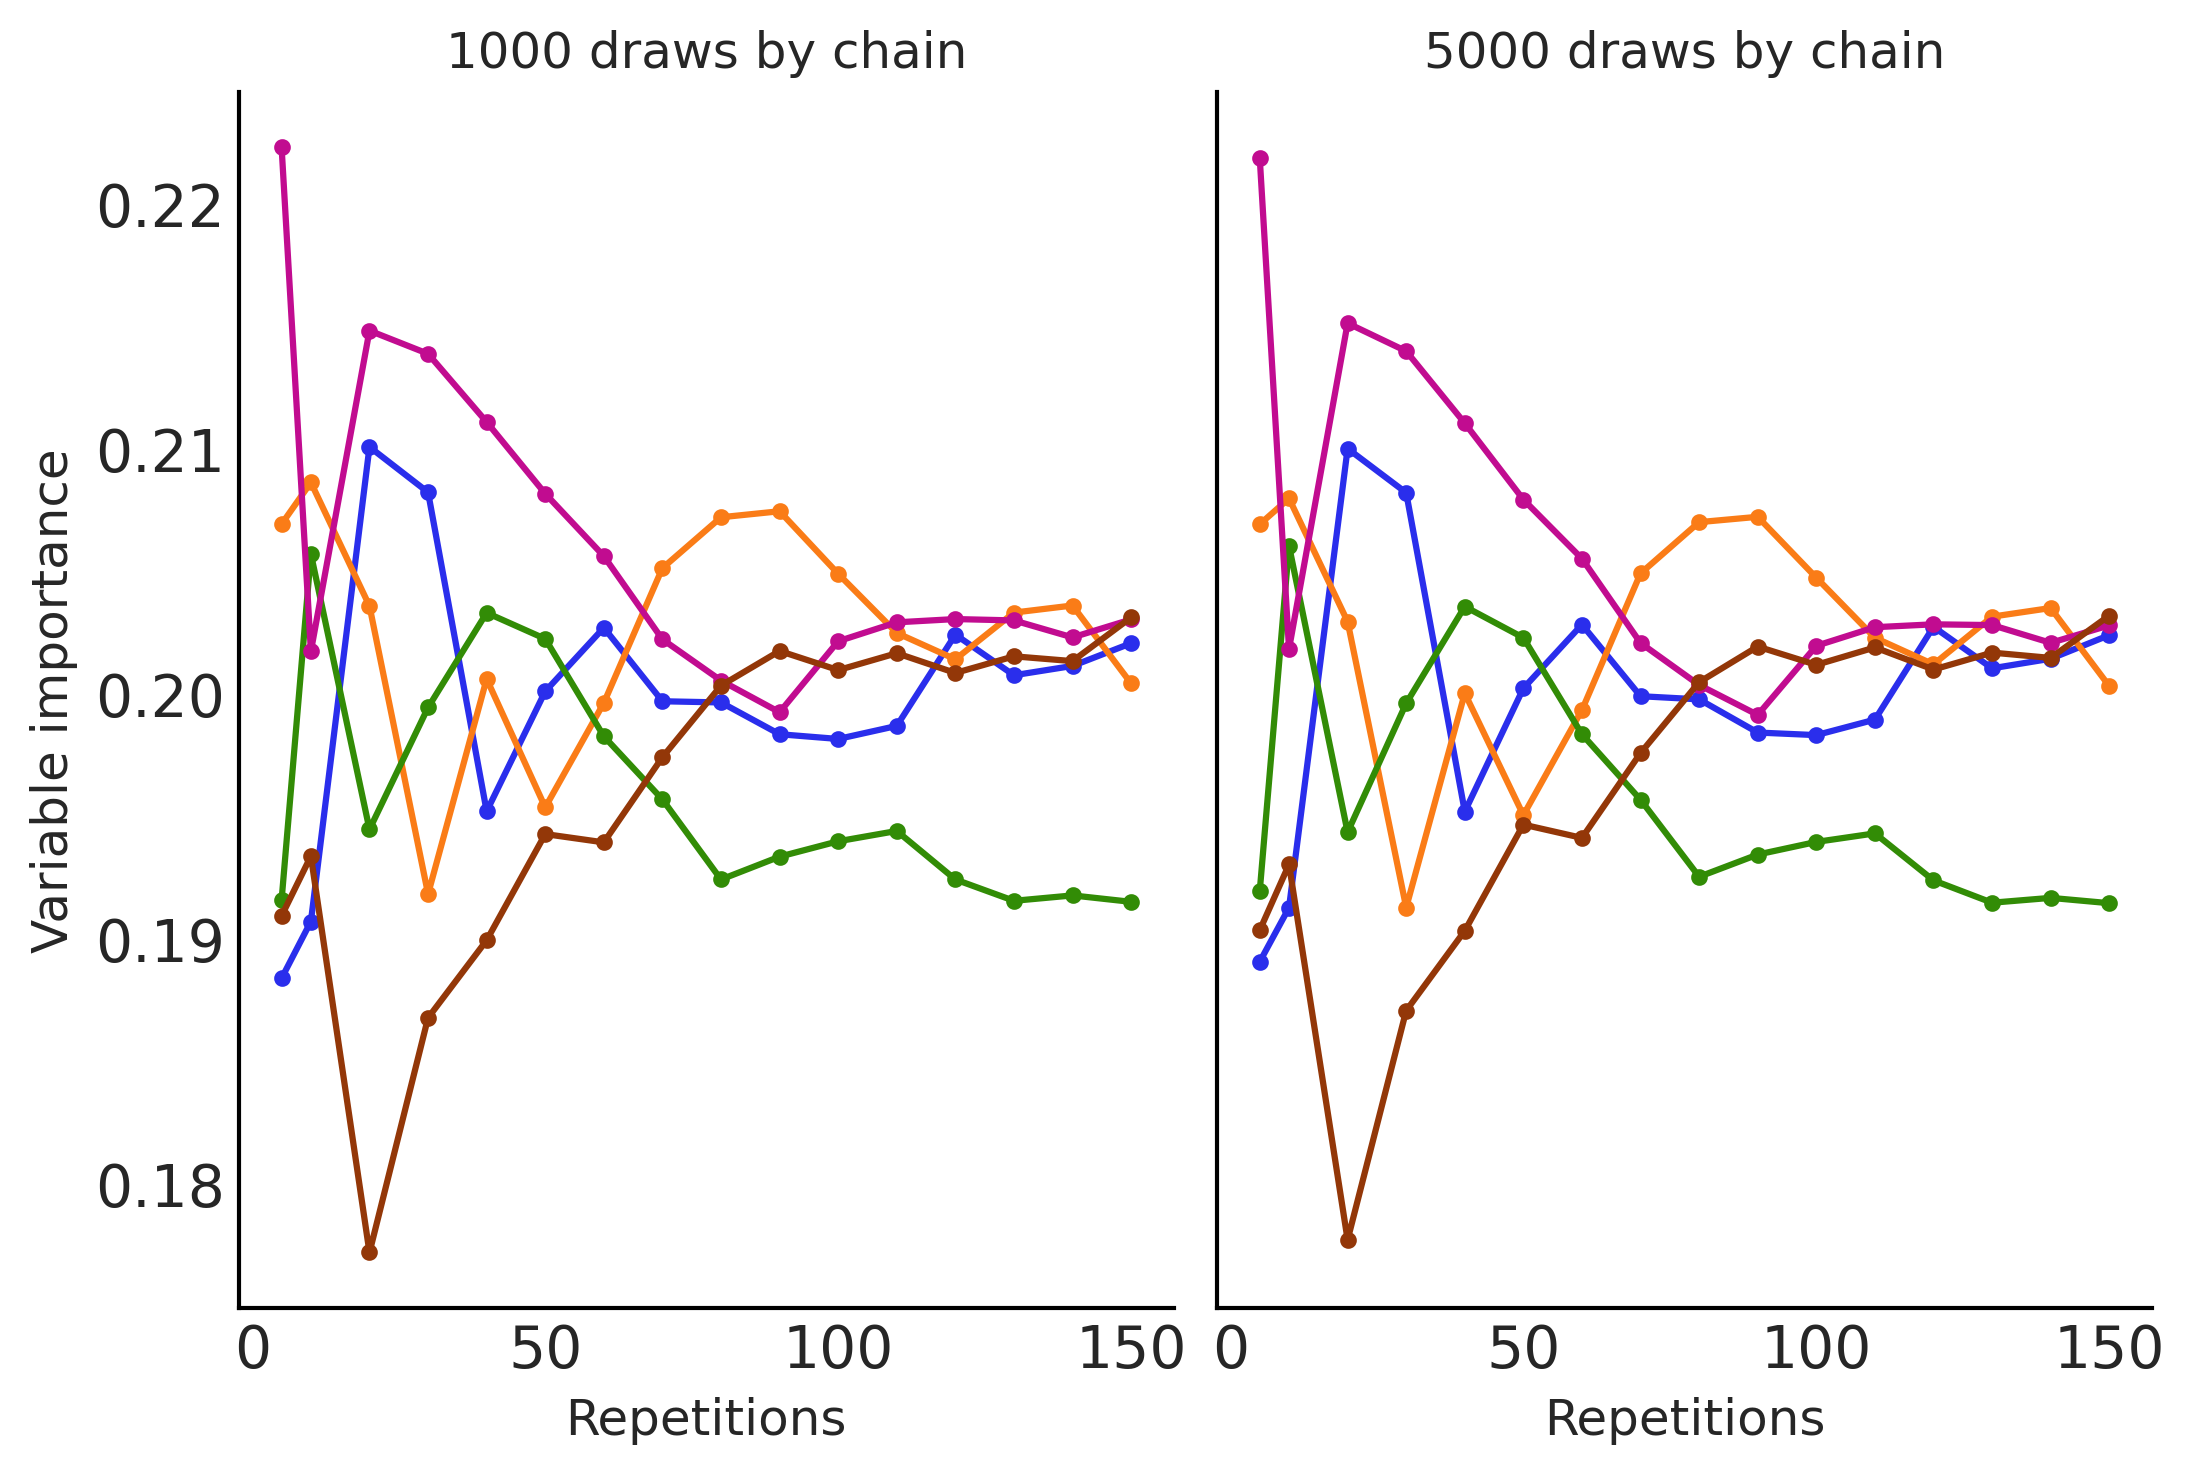

In [21]:
_, axes = plt.subplots(1, 2, sharey=True)
axes[0].plot(N, vi_v_mean_1k, ".-")
axes[1].plot(N, vi_v_mean_5k, ".-")

axes[0].set_title("1000 draws by chain", fontsize=12)
axes[1].set_title("5000 draws by chain", fontsize=12)
axes[0].set_ylabel("Variable importance", fontsize=12)
axes[0].set_xlabel("Repetitions", fontsize=12)
axes[1].set_xlabel("Repetitions", fontsize=12);

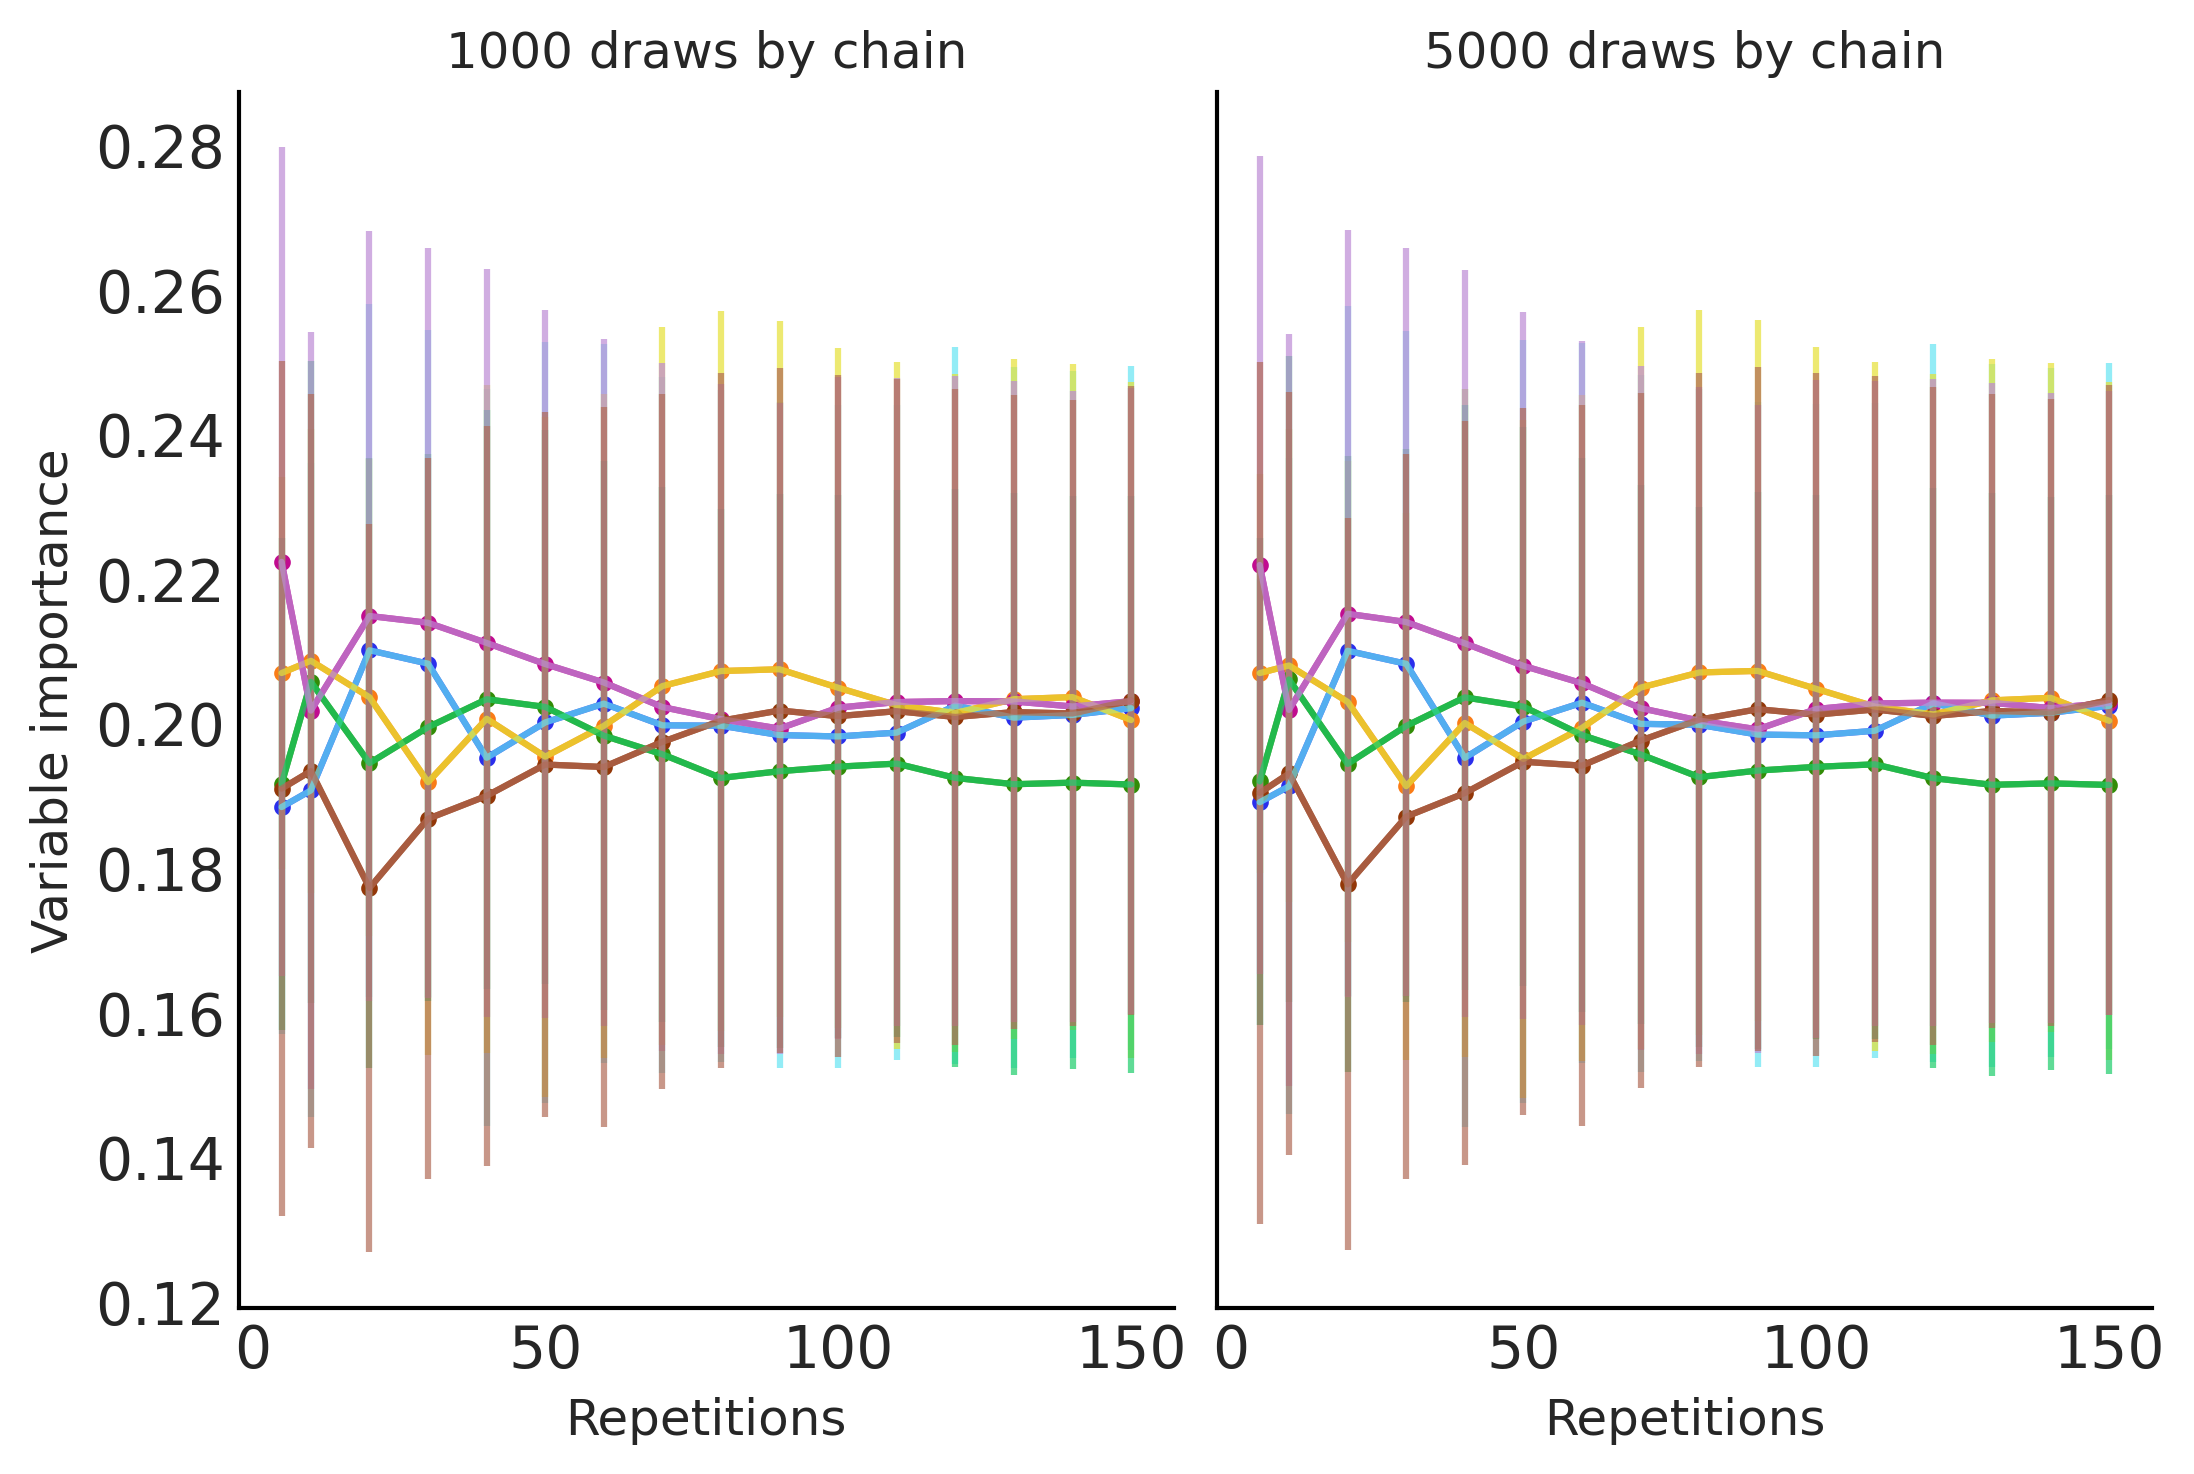

In [22]:
_, axes = plt.subplots(1, 2, sharey=True)

axes[0].plot(N, vi_v_mean_1k, ".-")
for i in range(X.shape[1]):
    axes[0].errorbar(x=N, y=vi_v_mean_1k[:, i], yerr=vi_v_std_1k[:, i], alpha=0.7)

axes[1].plot(N, vi_v_mean_5k, ".-")
for i in range(X.shape[1]):
    axes[1].errorbar(x=N, y=vi_v_mean_5k[:, i], yerr=vi_v_std_5k[:, i], alpha=0.7)

axes[0].set_title("1000 draws by chain", fontsize=12)
axes[1].set_title("5000 draws by chain", fontsize=12)
axes[0].set_ylabel("Variable importance", fontsize=12)
axes[0].set_xlabel("Repetitions", fontsize=12)
axes[1].set_xlabel("Repetitions", fontsize=12)
plt.savefig("VI-similar_150r_5k.png");